In [1]:
using DataFrames
using Dates
using Impute
using Loess
using Plots
using QuadGK
using Printf
using StatsPlots

In [2]:
d = [
    (Date(2020, 3, 15), 3),
    (Date(2020, 3, 16), 3),
    (Date(2020, 3, 17), 4),
    (Date(2020, 3, 18), 4),
    (Date(2020, 3, 19), 6),
    (Date(2020, 3, 20), 12),
    (Date(2020, 3, 21), 14),
    (Date(2020, 3, 22), 19),
    (Date(2020, 3, 23), 29),
    (Date(2020, 3, 24), 31),
    
    (Date(2020, 4, 3), 122, 10),
    (Date(2020, 4, 4), 137, 10),
    (Date(2020, 4, 5), 142, 10),
    (Date(2020, 4, 6), 154, 11),
    (Date(2020, 4, 7), 158, 12),
    
    (Date(2020, 4, 9), 170, 15),
    (Date(2020, 4, 10), 180, 15),
    (Date(2020, 4, 11), 193, 17),
    (Date(2020, 4, 12), 199, 20),
    (Date(2020, 4, 13), 204, 21),
    (Date(2020, 4, 14), 211, 21),
    (Date(2020, 4, 15), 217, 21),
    (Date(2020, 4, 16), 220, 21, 2),
    (Date(2020, 4, 17), 227, 21, 2),
    (Date(2020, 4, 18), 230, 21, 2),
    (Date(2020, 4, 19), 236, 21, 2),
    (Date(2020, 4, 20), 242, 21, 2),
    (Date(2020, 4, 21), 243, 21, 2),
    (Date(2020, 4, 22), 249, 21, 2),
    (Date(2020, 4, 23), 254, 21, 2),
    (Date(2020, 4, 24), 256, 21, 2),
    (Date(2020, 4, 25), 268, 21, 2),
    (Date(2020, 4, 26), 275, 22, 2),
    (Date(2020, 4, 27), 276, 23, 2),
    
    (Date(2020, 4, 29), 283, 23, 2),
    (Date(2020, 4, 30), 285, 23, 2),
    
    (Date(2020, 5, 1), 293, 23, 2),
    (Date(2020, 5, 2), 296, 23, 2),
    (Date(2020, 5, 3), 300, 23, 2),
    (Date(2020, 5, 4), 299, 24, 2),
    (Date(2020, 5, 5), 302, 25, 2),
    (Date(2020, 5, 6), 308, 26, 2),
    (Date(2020, 5, 7), 315, 26, 2),
    (Date(2020, 5, 8), 321, 27, 2),
    (Date(2020, 5, 9), 327, 27, 2),
    (Date(2020, 5, 10), 336, 28, 2),
    (Date(2020, 5, 11), 338, 28, 2),
    (Date(2020, 5, 12), 340, 28, 2),
    (Date(2020, 5, 13), 344, 29, 2),
    (Date(2020, 5, 14), 349, 28, 2),
    (Date(2020, 5, 15), 354, 28, 2),
    (Date(2020, 5, 16), 363, 29, 2),
    (Date(2020, 5, 17), 368, 31, 2),
    (Date(2020, 5, 18), 370, 32, 2),

    (Date(2020, 5, 20), 386, 32, 2),
    (Date(2020, 5, 21), 396, 34, 2),
    (Date(2020, 5, 22), 401, 34, 2),
    (Date(2020, 5, 23), 407, 34, 2),
    (Date(2020, 5, 24), 410, 36, 2),
    (Date(2020, 5, 25), 414, 36, 2),
    (Date(2020, 5, 26), 419, 37, 2),
    (Date(2020, 5, 27), 424, 38, 2),
    (Date(2020, 5, 28), 435, 38, 2),
    (Date(2020, 5, 29), 447, 41, 2),
    (Date(2020, 5, 30), 458, 41, 2),
    (Date(2020, 5, 31), 465, 41, 2),
    
    (Date(2020, 6, 1), 472, 42, 2),
    (Date(2020, 6, 2), 476, 42, 2),
    (Date(2020, 6, 3), 494, 47, 2),
    (Date(2020, 6, 4), 513, 48, 2),
    (Date(2020, 6, 5), 525, 49, 2),
    (Date(2020, 6, 6), 541, 49, 2),
    (Date(2020, 6, 7), 549, 50, 2),
    (Date(2020, 6, 8), 564, 52, 3),
    (Date(2020, 6, 9), 580, 53, 3),
    (Date(2020, 6, 10), 593, 53, 4),
    (Date(2020, 6, 11), 620, 53, 4),
    (Date(2020, 6, 12), 628, 53, 4),
    (Date(2020, 6, 13), 646, 55, 4),
    (Date(2020, 6, 14), 660, 56, 4),
    (Date(2020, 6, 15), 672, 57, 4),
    (Date(2020, 6, 16), 691, 61, 4),
    (Date(2020, 6, 17), 715, 63, 4),
    (Date(2020, 6, 18), 739, 59, 4),
    (Date(2020, 6, 19), 775, 58, 4),
    (Date(2020, 6, 20), 822, 59, 4),
    (Date(2020, 6, 21), 856, 61, 4),
    (Date(2020, 6, 22), 877, 61, 4),
    (Date(2020, 6, 23), 905, 62, 4),
    (Date(2020, 6, 24), 938, 62, 4),
    (Date(2020, 6, 25), 989, 65, 4),
    (Date(2020, 6, 26), 1036, 70, 4),
    (Date(2020, 6, 27), 1080, 75, 4),
    (Date(2020, 6, 28), 1113, 76, 4),
    (Date(2020, 6, 29), 1155, 80, 5),
    (Date(2020, 6, 30), 1179, 79, 5),

    (Date(2020, 7, 1), 1218, 84, 5),
    (Date(2020, 7, 2), 1268, 87, 5),
    (Date(2020, 7, 3), 1322, 89, 5),
    (Date(2020, 7, 4), 1379, 90, 5),
    (Date(2020, 7, 5), 1422, 92, 5),
    (Date(2020, 7, 6), 1470, 94, 6),

    (Date(2020, 7, 8), 1575, 98, 6),
    (Date(2020, 7, 9), 1644, 101, 6),
    (Date(2020, 7, 10), 1723, 102, 6),
    (Date(2020, 7, 11), 1794, 105, 6),
    (Date(2020, 7, 12), 1846, 107, 6),
    (Date(2020, 7, 13), 1909, 113, 6),
    (Date(2020, 7, 14), 1976, 120, 6),
    (Date(2020, 7, 15), 2016, 120, 7),
    (Date(2020, 7, 16), 2113, 123, 7),
    (Date(2020, 7, 17), 2183, 127, 7),
    (Date(2020, 7, 18), 2249, 130, 7),
    (Date(2020, 7, 19), 2325, 133, 7),
    (Date(2020, 7, 20), 2360, 140, 7),
    (Date(2020, 7, 21), 2415, 143, 8),
    (Date(2020, 7, 22), 2468, 145, 9),
    (Date(2020, 7, 23), 2520, 145, 9),
    (Date(2020, 7, 24), 2616, 147, 10),
    (Date(2020, 7, 25), 2660, 150, 11),
    (Date(2020, 7, 26), 2695, 153, 11),
];

In [3]:
dates = d[1][1] : Day(1) : d[end][1]
df = DataFrame(date=dates, day=1:length(dates), cases=missings(Int64, length(dates)))
for t in d
    df[df.date .== t[1], :cases] = [t[2]]
end
df.cases_inferred = Impute.interp(convert(Array{Union{Missing,Float64}}, df[:, :cases]))
first(df, 30)

,date,day,cases,cases_inferred
,Date,Int64,Int64?,Float64?
1,2020-03-15,1,3,3.0
2,2020-03-16,2,3,3.0
3,2020-03-17,3,4,4.0
4,2020-03-18,4,4,4.0
5,2020-03-19,5,6,6.0
6,2020-03-20,6,12,12.0
7,2020-03-21,7,14,14.0
8,2020-03-22,8,19,19.0
9,2020-03-23,9,29,29.0


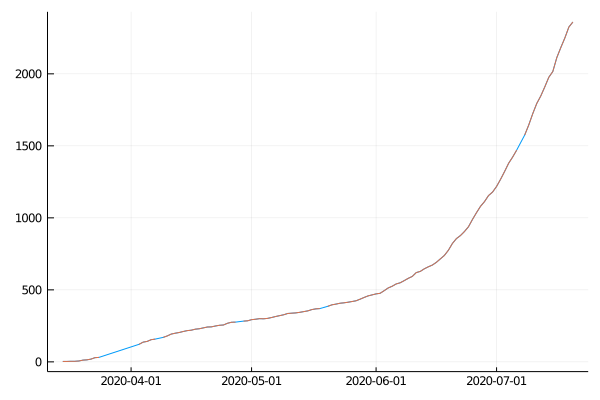

In [4]:
@df df plot(:date, :cases_inferred, legend=false)
@df df plot!(:date, :cases)

In [5]:
ws = append!(collect(1/15:1/15:14/15), ones(14))
growth = Float64[]
active_cases = Float64[]
for i in 1:length(axes(df, 1))
    cases_yesterday = i > 1 ? df[i-1, :cases_inferred] : 0
    cases_today = df[i, :cases_inferred]
    push!(growth, cases_today - cases_yesterday)
    push!(active_cases,
        round(sum(
            [j < 1 ? 0 : growth[j] for j in i-27:i] .* ws
        ))
    )
end
df.growth = growth
df.active_cases = active_cases
last(df, 30)

,date,day,cases,cases_inferred,growth,active_cases
,Date,Int64,Int64?,Float64?,Float64,Float64
1,2020-06-21,99,856,856.0,34.0,387.0
2,2020-06-22,100,877,877.0,21.0,397.0
3,2020-06-23,101,905,905.0,28.0,414.0
4,2020-06-24,102,938,938.0,33.0,436.0
5,2020-06-25,103,989,989.0,51.0,474.0
6,2020-06-26,104,1036,1036.0,47.0,508.0
7,2020-06-27,105,1080,1080.0,44.0,538.0
8,2020-06-28,106,1113,1113.0,33.0,558.0
9,2020-06-29,107,1155,1155.0,42.0,586.0


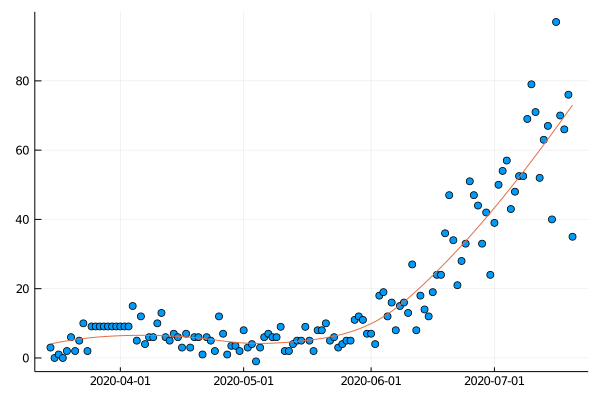

In [6]:
growth_model = loess(df[:, :day], convert(Array{Float64}, df[:, :growth]));
predicted_growth(day) = predict(growth_model, [(day - dates[1]).value + 1.0]);
@df df scatter(:date, :growth, legend=false)
plot!(dates, predicted_growth.(dates))

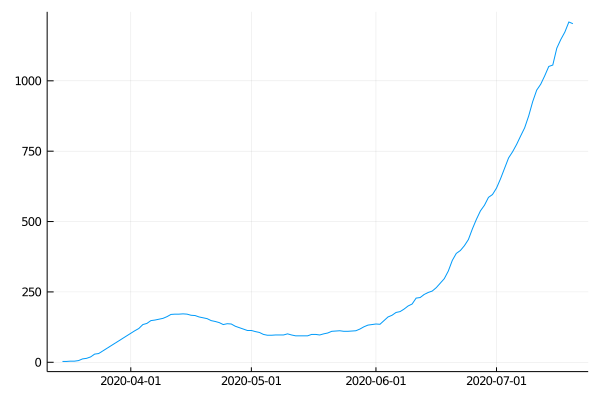

In [7]:
@df df plot(:date, :active_cases, legend=false)

In [8]:
davis_county_population = 356_000
current_growth = predicted_growth(dates[end])
@printf("Current growth: %12.2f\nYears to infect all: %7.2f\nActive cases: %11d",
    current_growth,
    davis_county_population / current_growth / 365,
    df.active_cases[end])

Current growth:        73.01
Years to infect all:   13.36
Active cases:        1203